# Week4授業前課題1 アヤメの分類

## 1.このテキストについて

テキストの目的
- 教師あり学習（分類問題）の概観を知る
- scikit-laernを使い分類を行えるようにする
- 手法の簡単な比較をする

どのように学ぶか
定番のデータセットを通じて、分類問題を解く流れやライブラリの使い方を学びます。

## 2.アヤメの分類

Week3で使用したirisデータセットを使い、分類問題を解く練習をします。

irisデータセットはカナダのガスペ半島のある牧草地で同じ日に採取された以下の3種類のアヤメ、合計150本のデータでした。

- Iris setosa - Wikipedia
- Iris virgicolor - Wikipedia
- Iris virginica - Wikipedia

4種類の特徴量（説明変数）からアヤメの種類を推測する問題が設定できます。アヤメの種類を 分類 するので、こういったものを分類問題と呼びます。

今回使う手法の一覧
scikit-laernを使い以下の手法で学習と推定を行っていきます。それぞれの手法についての詳細は今の段階では扱いません。ライブラリを使えばどれも気軽に利用できることや、手法毎の結果に違いがあることを簡単に見ていきます。

- 最近傍法
- ロジスティック回帰
- SVM
- 決定木
- ランダムフォレスト

## 3.分類問題の流れ

まず、最近傍法を例に分類問題を解く基本的な流れを紹介します。課題の後半ではこれを参考に他の手法にも適用してもらいます。

この流れについては後々より深く学び、実践していきます。今回の課題では大まかな流れの把握を行ってください。

### 練習のための準備

練習する上で結果の可視化を行いたいため、特徴量は4つの中で2つだけを使うことにします。こうすることで2次元の散布図を描き確認することができます。また、問題を単純化するためアヤメの種類を2つだけ使うことにします。分類対象が2種類の場合を 2値分類 と呼び、それ以上の 多値分類 とは区別をします。それぞれで手法や評価方法が変わります。今回はまずより基本的な2値分類を行います。

### 【課題1】練習のために特徴量とカテゴリを選択

選び方は合計18通りありますが、以下の組み合わせで練習することにします。irisデータセットをWeek3同様に取得した後、データフレームからこれらを抜き出してください。

- virgicolorとvirginica
- sepal_lengthとpetal_length

《実際の問題では？》

実際の問題を解く上でも結果の可視化は有効です。しかし、そのために学習や推定に使う特徴量を2つに絞るのは望ましくありません。そのため学習や推定は多次元で行い、可視化をする際にだけ主成分分析などの特徴抽出手法を適用するといったことが行われます。また、Week3で利用した散布図行列を使い可視化することも可能です。

In [68]:
# Numpy
import numpy as np

# Dataframe operations
import pandas as pd

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Scalers
from sklearn.preprocessing import StandardScaler

# Hold-out
from sklearn.model_selection import train_test_split

# Linear-models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.svm import LinearSVC

# Dicision Tree
import pydotplus
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn import datasets
from IPython.display import Image

# Random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

# KNN
from sklearn.neighbors import KNeighborsClassifier

# Evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# iris data-set
from sklearn.datasets import load_iris

In [2]:
iris_dataset = load_iris()
columns_list = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
df = pd.DataFrame(iris_dataset['data'], columns=columns_list)
df['target'] = iris_dataset['target']

df2 = df[df['target'] != 0].loc[:, ['sepal_length', 'petal_length', 'target']]
df2.head()

,sepal_length,petal_length,target
50,7.0,4.7,1
51,6.4,4.5,1
52,6.9,4.9,1
53,5.5,4.0,1
54,6.5,4.6,1


## 【問題2】データの分析

まずはデータの分析を行いますが、これはWeek3の課題1で行いました。その際出力した散布図行列を見ることで、先ほどの18通りそれぞれの散布図も確認できます。sepal_lengthとpetal_lengthを使い、virgicolorとvirginicaを分類するのは少し難しそうな状況であることが分かるはずです。

ここでは復習を兼ねて、抜き出したデータの散布図と箱ひげ図（boxplot）、バイオリン図（violinplot）を表示してください。

《実際の問題では？》

このデータ分析の結果を元に前処理として特徴量エンジニアリングを行っていきます。

今回はsepal_lengthとpetal_lengthを抜き出しましたが、分析した上で、問題を少々難しくするための前処理をしたと言えます。

In [3]:
# 散布図
def scatter_by_yclass(df, x1, x2, y_column):
    
    class_name = df[y_column].unique()
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111)
    
    for i in range(len(class_name)):
        df_ = df[df[y_column] == class_name[i]]
        ax.scatter(df_[x1], df_[x2], label=class_name[i])
    
    ax.set_xlabel(x1)
    ax.set_ylabel(x2)
    
    plt.legend(loc='best')
    plt.grid(True, alpha=.5)
    plt.show()
    
# 箱ひげ図orバイオリン図
def my_boxplot(df, box=True, violin=False):
    
    data = [df[name] for name in df]
    n = len(data)

    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111)
    
    if box:
        ax.boxplot(data)
    if violin:
        ax.violinplot(data)
    
    ax.set_xticks(list(range(1, n+1)))
    ax.set_xticklabels(df)
    
    plt.grid(True, alpha=.5)
    plt.show()


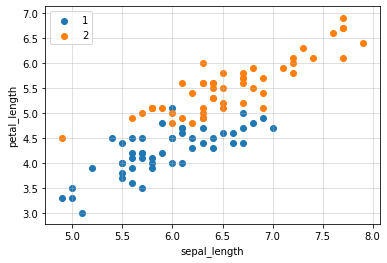

In [4]:
scatter_by_yclass(df2, 'sepal_length', 'petal_length', 'target')

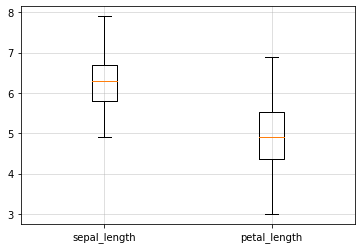

In [5]:
my_boxplot(df2.drop('target', axis=1))

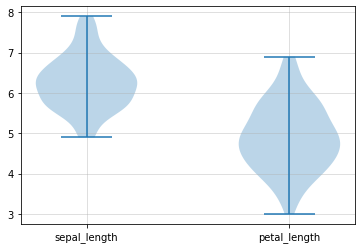

In [6]:
my_boxplot(df2.drop('target', axis=1), box=False, violin=True)

### 前処理

データに加工をしていきます。

## 【問題3】前処理・訓練データと検証データの分割
前処理の一貫として、訓練データと検証データの分割を行います。今回は訓練データ75%、検証データ25%として分割してください。

scikit-learnのtrain_test_splitが利用できます。公式ドキュメントのExamplesを参考に動かしてください。

sklearn.model_selection.train_test_split — scikit-learn 0.21.3 documentation

《注意点》

データの分析まではPandasのDataFrameを使用してきました。しかし、scikit-learnはNumPyのndarrayを想定して作られています。そのため、この段階でndarrayへの変換を行いましょう。特徴量（説明変数）をX、正解（目的変数）をyというndarrayに格納します。

《分割する理由》

分類問題の目的は未知のデータを正しく分類することです。その目的が達成できているかを確認するため、実際には答えの分かっているデータの一部を学習には使わず残しておきます。この学習に使用していないデータで推定を行い、そこから求めた指標値によって検証します。学習に使うデータを訓練データ、検証に使うデータが検証データで、一般的に7対3から8対2程度の割合にします。

In [7]:
X = df2.loc[:, ['sepal_length', 'petal_length']]
y = df2.loc[:, 'target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [8]:
X_train.shape

(75, 2)

In [9]:
X_test.shape

(25, 2)

In [10]:
y_train.shape

(75,)

In [11]:
y_test.shape

(25,)

In [12]:
X_train.head()

,sepal_length,petal_length
98,5.1,3.0
56,6.3,4.7
149,5.9,5.1
132,6.4,5.6
126,6.2,4.8


In [13]:
X_test.head()

,sepal_length,petal_length
76,6.8,4.8
136,6.3,5.6
52,6.9,4.9
105,7.6,6.6
125,7.2,6.0


## 【問題4】前処理・標準化

分類精度をあげるための加工を行います。手法ごとに適切な方法は異なりますが、ここでは一例として 標準化 を行うことにします。

標準化を行うライブラリもscikit-learnに用意されています。これを使って標準化してください。

sklearn.model_selection.train_test_split — scikit-learn 0.21.3 documentation

《注意点》

標準化は訓練用のデータでfitを行い、訓練用、検証用双方のデータにtransformを行います。検証データは学習の段階には存在しない未知のデータの代わりなので、標準化のための平均や標準偏差の計算に使ってはいけません。

《実際の問題での前処理は？》

アヤメのデータセットのように綺麗で扱いやすい状況で提供されることはまずありません。分析を行いながら、様々な加工が必要になってきます。例えばWeek3の課題2で行った欠損値の確認の後、場合により欠損値の補間も行います。外れ値の確認や、複数のデータセットの整理などもあります。

In [14]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

In [15]:
X_train_std[:5,:]

array([[-1.77029021, -2.29778941],
       [ 0.03817879, -0.24187257],
       [-0.56464421,  0.24187257],
       [ 0.18888454,  0.84655399],
       [-0.11252696, -0.12093628]])

In [16]:
X_test_std[:5,:]

array([[ 7.91707539e-01, -1.20936285e-01],
       [ 3.81787899e-02,  8.46553995e-01],
       [ 9.42413289e-01,  2.14825997e-15],
       [ 1.99735354e+00,  2.05591684e+00],
       [ 1.39453054e+00,  1.33029913e+00]])

## 【問題5】学習と推定

最近傍法（k-nearest neighbors, k-nn）で学習を行います。scikit-learnの公式ドキュメントのExamplesを参考に、k-nnの学習を行ってください。ここで入力するのは訓練データです。

sklearn.neighbors.KNeighborsClassifier — scikit-learn 0.21.3 documentation

学習が終わった後、検証データをpredictメソッドに入力し、推定を行ってください。

パラメータが複数ありますが、今はそれらの理解を重視しません。最も基本的な要素として、n_neighborsの数があるため、これは複数試してみましょう。デフォルトの5、および1と3を最低限行ってください。5の場合を5-nn、3の場合を3-nnのように呼びます。

### 5-nn

In [17]:
neigh5 = KNeighborsClassifier()
neigh5.fit(X_train_std, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [18]:
y_pred5 = neigh5.predict(X_test_std)
y_pred5_train = neigh5.predict(X_train_std)
accuracy_score(y_test, y_pred5)

0.88

### 1-nn

In [19]:
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(X_train_std, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [20]:
y_pred = neigh.predict(X_test_std)
accuracy_score(y_test, y_pred)

0.84

### 3-nn

In [21]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train_std, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [22]:
y_pred = neigh.predict(X_test_std)
accuracy_score(y_test, y_pred)

0.92

### 8-nn

In [23]:
neigh = KNeighborsClassifier(n_neighbors=8)
neigh.fit(X_train_std, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=8, p=2,
                     weights='uniform')

In [24]:
y_pred = neigh.predict(X_test_std)
accuracy_score(y_test, y_pred)

0.92

## 【問題6】評価
検証データの特徴量を入力して得られた推定値と、検証データの正解値の近さを計算し、学習したモデルを評価します。

2値分類を評価するための指標値には Accuracy（正解率）、Precision（適合率）、Recall（再現率）、F値 があります。それぞれの意味を理解するには、 混同行列（confusion matrix） を見ることになります。

- scikit-learnを使い4種類の指標を計算する
- 混同行列をscikit-learnを使い表示する
- 4種類の指標値の意味について簡単に調査して文章でまとめる

sklearn.metrics.accuracy_score — scikit-learn 0.21.3 documentation

sklearn.metrics.precision_score — scikit-learn 0.21.3 documentation

sklearn.metrics.recall_score — scikit-learn 0.21.3 documentation

sklearn.metrics.f1_score — scikit-learn 0.21.3 documentation

sklearn.metrics.confusion_matrix — scikit-learn 0.21.3 documentation

### scikit-learnを使い4種類の指標を計算する

In [25]:
# Accuracy（正解率）
accuracy_score(y_test, y_pred5)

0.88

In [26]:
# Precision（適合率）
precision_score(y_test, y_pred5, pos_label=2)

0.8

In [27]:
# Recall（再現率）
recall_score(y_test, y_pred5, pos_label=2)

1.0

In [28]:
# F値
f1_score(y_test, y_pred5, pos_label=2)

0.888888888888889

In [29]:
# 関数化
def classifier_evaluation(y_test, y_pred, pos_label=None):
    values = {'Accuracy ':0, 
              'Precision':0, 
              'Recall   ':0,
              'F        ':0}
    if pos_label != None:
        values['Accuracy '] = accuracy_score(y_test, y_pred)   # Accuracy（正解率）
        values['Precision'] = precision_score(y_test, y_pred) # Precision（適合率）
        values['Recall   '] = recall_score(y_test, y_pred)       # Recall（再現率）
        values['F        '] = f1_score(y_test, y_pred)                # F値
    else:
        values['Accuracy '] = accuracy_score(y_test, y_pred)   # Accuracy（正解率）
        values['Precision'] = precision_score(y_test, y_pred, pos_label=pos_label) # Precision（適合率）
        values['Recall   '] = recall_score(y_test, y_pred, pos_label=pos_label)       # Recall（再現率）
        values['F        '] = f1_score(y_test, y_pred, pos_label=pos_label)                # F値
        
    # 表示
    for key, value in values.items():
        print("{} : {:.3f}".format(key, value))
        
    return values
        

In [30]:
# 5-nn 評価
print('トレーニングデータの精度')
results01 = classifier_evaluation(y_train, y_pred5_train, pos_label=2)
print('\nテストデータの精度')
results02 = classifier_evaluation(y_test, y_pred5, pos_label=2)

トレーニングデータの精度
Accuracy  : 0.933
Precision : 0.944
Recall    : 0.919
F         : 0.932

テストデータの精度
Accuracy  : 0.880
Precision : 1.000
Recall    : 0.769
F         : 0.870


### 混同行列をscikit-learnを使い表示する

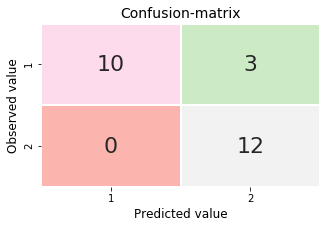

In [31]:
def cf_matrix(data):
    plt.figure(figsize=(5, 3))
    sns.heatmap(data, cmap='Pastel1', cbar=False, annot_kws={"size": 22}, annot=True, fmt="d", linewidths=1)
    plt.title("Confusion-matrix", fontsize=14)
    plt.xlabel("Predicted value", fontsize=12)
    plt.ylabel("Observed value", fontsize=12)
    plt.show()

confusion = confusion_matrix(y_test, y_pred5)
cf_df = pd.DataFrame(confusion, index=[1,2], columns=[1,2])
cf_matrix(cf_df)

### 4種類の指標値の意味について簡単に調査して文章でまとめる

### ■正解率（accuracy）
予測の正確さを表す指標

$$
\begin{equation*}
  accuracy = 
  \frac{TP + TN}{TP + TN + FP + FN}
\end{equation*}
$$

$$
\begin{equation*}
  ※参考）error\_rate = 1 - accuracy
\end{equation*}
$$



### ■適合率（precision, PPV）
陽性であると予測されたものがどの程度実際に陽性であったかを測定する指標（陽性的中立 PPV）

FP（偽陽性）が大きくなると適合率は小さくなる。偽陽性を避けたい（抑えたい）場合に指標として用いる。

$$
\begin{equation*}
  precision = 
  \frac{TP}{TP + FP}
\end{equation*}
$$

### ■再現率（recall, TPR）
実際に陽性のサンプルのうち、陽性と予測されたものの割合。

すべての陽性サンプルを陽性だと判断する必要がある場合、つまり偽陰性を避けることが重要な場合に用いる指標

$$
\begin{equation*}
  recall = 
  \frac{TP}{TP + FN}
\end{equation*}
$$

### ■F値（F-measure, F-score, F1-score）
適合率と再現率の調和平均。

$$
\begin{equation*}
  F = 
  2 × \frac{適合率 × 再現率}{適合率 + 再現率}
\end{equation*}
$$

## 【問題7】可視化
評価の一貫として可視化を行います。今回の場合2次元の特徴量で分類を行いましたから、散布図で可視化が可能です。以下にどう分割するかという 決定領域 を描く関数を用意しました。これを利用して可視化を行ってください。Xとyには訓練データまたは検証データを与えます。

3-nnの決定領域を表示した例が以下です。

<img src="../../img/1.png">

この例では訓練データをプロットし、どのように学習したかを見ています。一方で、検証データをプロットすればどういった特徴量のものが間違って分類されたかを見ることができます。

In [32]:
## 問題10に合わせて修正済み

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

def decision_region(X, y, model, step=0.01, title='decision region', 
                    xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica'],
                    n_class=2):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。

    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """

    # setting
    if n_class == 2:
        scatter_color = ['red', 'blue']
        contourf_color = ['pink', 'skyblue']
    elif n_class == 3:
        scatter_color = ['green', 'red', 'blue']
        contourf_color = ['lightgreen', 'pink', 'skyblue']

    # pred
    mesh_f0, mesh_f1 = np.meshgrid(np.arange(np.min(X[:,0])-0.5, 
                                             np.max(X[:,0])+0.5, step), 
                                   np.arange(np.min(X[:,1])-0.5, 
                                             np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)
    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

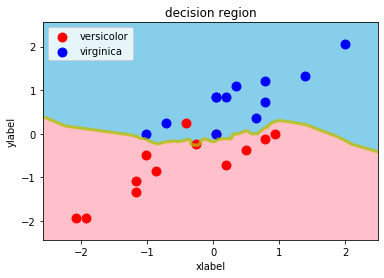

In [33]:
decision_region(X_test_std, y_test, neigh5)

### 手法の改善

実際の問題では指標値や可視化を元に手法を改善していきますが、この課題では扱いません。

## 【問題8】他の手法の学習
以下の全ての手法について学習・推定・評価・可視化を行ってください。そして、指標値を１つの表にまとめてください。その表と決定領域を利用して結果を簡単に考察してください。どの手法がどの指標値で良かったかや、どういった決定領域になっていたかを述べてください。

- 最近傍法
- ロジスティック回帰
- SVM
- 決定木
- ランダムフォレスト

公式ドキュメントへのリンクは以下です。それぞれ調整すべき引数（ハイパーパラメータ）がありますが、この課題では扱いません。まずはデフォルトの値で実行してください。

- sklearn.neighbors.KNeighborsClassifier — scikit-learn 0.21.3 documentation
- sklearn.linear_model.LogisticRegression — scikit-learn 0.21.3 documentation
- sklearn.svm.SVC — scikit-learn 0.21.3 documentation
- sklearn.tree.DecisionTreeClassifier — scikit-learn 0.21.3 documentation
- sklearn.ensemble.RandomForestClassifier — scikit-learn 0.21.3 documentation

《実際の問題では？》

ハイパーパラメータの調整は パラメータチューニング と呼ばれる工程で、その手法としてグリッドサーチなどが存在します。

### 【以降の実行結果の考察】

ロジスティック回帰、サポートベクターマシンでは精度に差は見られなかった。

最近傍法は、5-nnでは上記アルゴリズムより精度が落ちているが、3-nn, 8-nnでは上記と同様の精度となっている。

決定木・ランダムフォレストに関してはトレーニングデータへの当てはまりが非常に良い反面、

他のアルゴリズムよりもテストデータへの精度が落ちているため、トレーニングデータにオーバーフィッティングしているものと見られる。

### ロジスティック回帰

In [34]:
# ロジスティック回帰クラスを初期化
model1 = LogisticRegression()

# トレーニングデータで学習
model1.fit(X_train_std, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [35]:
# 予測
y_pred1 = model1.predict(X_test_std)
y_pred1_train = model1.predict(X_train_std)

In [36]:
# 評価
print('トレーニングデータの精度')
results11 = classifier_evaluation(y_train, y_pred1_train, pos_label=2)
print('\nテストデータの精度')
results12 = classifier_evaluation(y_test, y_pred1, pos_label=2)

トレーニングデータの精度
Accuracy  : 0.933
Precision : 0.921
Recall    : 0.946
F         : 0.933

テストデータの精度
Accuracy  : 0.920
Precision : 1.000
Recall    : 0.846
F         : 0.917


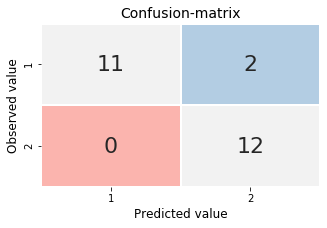

In [37]:
# 混同行列
cf1 = confusion_matrix(y_test, y_pred1)
cfdf1 = pd.DataFrame(cf1, index=[1,2], columns=[1,2])
cf_matrix(cfdf1)

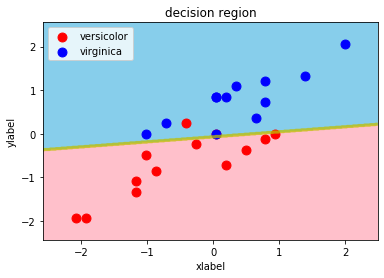

In [38]:
# 可視化
decision_region(X_test_std, y_test, model1)

### サポートベクターマシン

In [39]:
# SVMクラスの初期化
model2 = LinearSVC()

# トレーニングデータで学習
model2.fit(X_train_std, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [40]:
# 予測
y_pred2 = model2.predict(X_test_std)
y_pred2_train = model2.predict(X_train_std)

In [41]:
# 評価
print('トレーニングデータの精度')
results21 = classifier_evaluation(y_train, y_pred2_train, pos_label=2)
print('\nテストデータの精度')
results22 = classifier_evaluation(y_test, y_pred2, pos_label=2)

トレーニングデータの精度
Accuracy  : 0.960
Precision : 0.972
Recall    : 0.946
F         : 0.959

テストデータの精度
Accuracy  : 0.920
Precision : 1.000
Recall    : 0.846
F         : 0.917


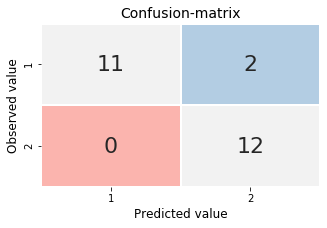

In [42]:
# 混同行列
cf2 = confusion_matrix(y_test, y_pred2)
cfdf2 = pd.DataFrame(cf2, index=[1,2], columns=[1,2])
cf_matrix(cfdf2)

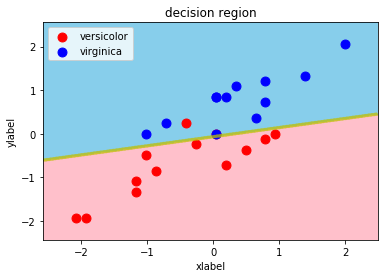

In [43]:
# 可視化
decision_region(X_test_std, y_test, model2)

### 決定木

In [44]:
# 決定木クラスの初期化
model3 = DecisionTreeClassifier()

# 学習
model3.fit(X_train_std, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [45]:
# 予測
y_pred3 = model3.predict(X_test_std)
y_pred3_train = model3.predict(X_train_std)

In [46]:
# 評価
print('トレーニングデータの精度')
results31 = classifier_evaluation(y_train, y_pred3_train, pos_label=2)
print('\nテストデータの精度')
results32 = classifier_evaluation(y_test, y_pred3, pos_label=2)

トレーニングデータの精度
Accuracy  : 1.000
Precision : 1.000
Recall    : 1.000
F         : 1.000

テストデータの精度
Accuracy  : 0.880
Precision : 1.000
Recall    : 0.769
F         : 0.870


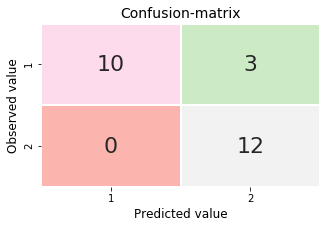

In [47]:
# 混同行列
cf3 = confusion_matrix(y_test, y_pred3)
cfdf3 = pd.DataFrame(cf3, index=[1,2], columns=[1,2])
cf_matrix(cfdf3)

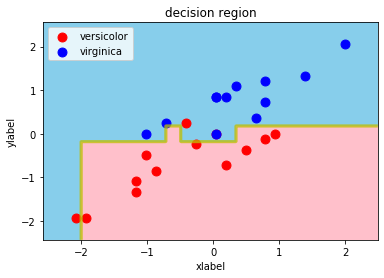

In [48]:
# 可視化
decision_region(X_test_std, y_test, model3)

### ランダムフォレスト

In [49]:
# ランダムフォレストクラスの初期化
model4 = RandomForestClassifier()

# 学習
model4.fit(X_train_std, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [50]:
# 予測
y_pred4 = model4.predict(X_test_std)
y_pred4_train = model4.predict(X_train_std)

In [51]:
# 評価
print('トレーニングデータの精度')
results41 = classifier_evaluation(y_train, y_pred4_train, pos_label=2)
print('\nテストデータの精度')
results42 = classifier_evaluation(y_test, y_pred4, pos_label=2)

トレーニングデータの精度
Accuracy  : 1.000
Precision : 1.000
Recall    : 1.000
F         : 1.000

テストデータの精度
Accuracy  : 0.880
Precision : 1.000
Recall    : 0.769
F         : 0.870


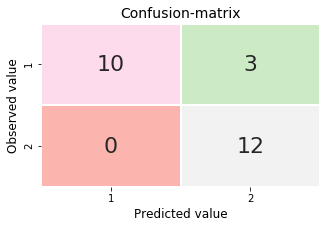

In [52]:
# 混同行列
cf4 = confusion_matrix(y_test, y_pred4)
cfdf4 = pd.DataFrame(cf4, index=[1,2], columns=[1,2])
cf_matrix(cfdf4)

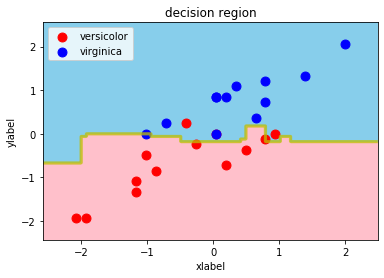

In [53]:
# 可視化
decision_region(X_test_std, y_test, model4)

In [54]:
index = results01.keys()
columns = [['5-nn','5-nn', 
            'LogisticRegression', 'LogisticRegression', 
            'SVM', 'SVM', 
            'DecisionTree', 'DecisionTree', 
            'RandomForest', 'RandomForest'],
           ['train', 'test', 
            'train', 'test', 
            'train', 'test', 
            'train', 'test', 
            'train', 'test']]

results_ndarray = np.zeros([4, 10])
results_ndarray[:, 0] = np.array([i for i in results01.values()])
results_ndarray[:, 1] = np.array([i for i in results02.values()])
results_ndarray[:, 2] = np.array([i for i in results11.values()])
results_ndarray[:, 3] = np.array([i for i in results12.values()])
results_ndarray[:, 4] = np.array([i for i in results21.values()])
results_ndarray[:, 5] = np.array([i for i in results22.values()])
results_ndarray[:, 6] = np.array([i for i in results31.values()])
results_ndarray[:, 7] = np.array([i for i in results32.values()])
results_ndarray[:, 8] = np.array([i for i in results41.values()])
results_ndarray[:, 9] = np.array([i for i in results42.values()])

pd.DataFrame(results_ndarray, index=index, columns=columns)

5-nn           LogisticRegression                 SVM  \
              train      test              train      test     train   
Accuracy   0.933333  0.880000           0.933333  0.920000  0.960000   
Precision  0.944444  1.000000           0.921053  1.000000  0.972222   
Recall     0.918919  0.769231           0.945946  0.846154  0.945946   
F          0.931507  0.869565           0.933333  0.916667  0.958904   

                    DecisionTree           RandomForest            
               test        train      test        train      test  
Accuracy   0.920000          1.0  0.880000          1.0  0.880000  
Precision  1.000000          1.0  1.000000          1.0  1.000000  
Recall     0.846154          1.0  0.769231          1.0  0.769231  
F          0.916667          1.0  0.869565          1.0  0.869565

## 【問題9】（アドバンス課題）標準化の有無の比較
前処理として標準化を行いましたが、これを行わなかった場合どのような結果が得られるでしょうか。各手法に対しての指標値の表と決定領域の図を作成し比較および考察を行ってください。考察には標準化が機械学習の前処理としてどのような意味があるかを絡めてください。

### 【考察】
標準化せずに学習させた場合、ほとんどのモデルで精度が悪化した。

しかしながら、最近傍法に関しては標準化しない方が精度が高く、標準化すると必ず精度が上がるという保証はないため、

どのモデルを使用するにしても、標準化した場合・しない場合を双方実行して精度を確認しながら進める必要がある。

### 最近傍法

トレーニングデータの精度
Accuracy  : 0.960
Precision : 0.972
Recall    : 0.946
F         : 0.959

テストデータの精度
Accuracy  : 0.920
Precision : 1.000
Recall    : 0.846
F         : 0.917


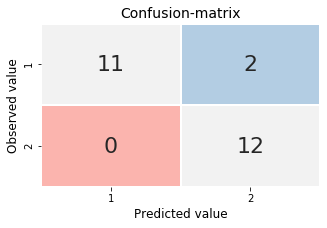

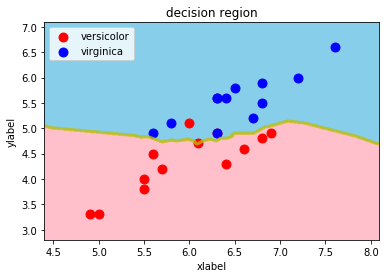

In [55]:
neigh5 = KNeighborsClassifier()
neigh5.fit(X_train, y_train)

y_pred5 = neigh5.predict(X_test)
y_pred5_train = neigh5.predict(X_train)

# 5-nn 評価
print('トレーニングデータの精度')
results01 = classifier_evaluation(y_train, y_pred5_train, pos_label=2)
print('\nテストデータの精度')
results02 = classifier_evaluation(y_test, y_pred5, pos_label=2)

confusion = confusion_matrix(y_test, y_pred5)
cf_df = pd.DataFrame(confusion, index=[1,2], columns=[1,2])
cf_matrix(cf_df)

decision_region(np.array(X_test), y_test, neigh5)

### ロジスティック回帰

トレーニングデータの精度
Accuracy  : 0.947
Precision : 0.923
Recall    : 0.973
F         : 0.947

テストデータの精度
Accuracy  : 0.880
Precision : 1.000
Recall    : 0.769
F         : 0.870


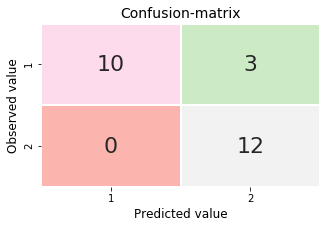

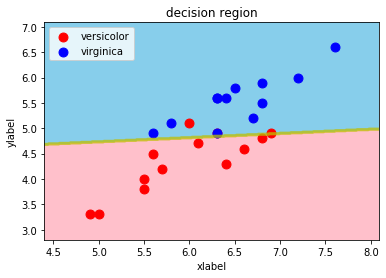

In [56]:
# ロジスティック回帰クラスを初期化
model1 = LogisticRegression()

# トレーニングデータで学習
model1.fit(X_train, y_train)

# 予測
y_pred1 = model1.predict(X_test)
y_pred1_train = model1.predict(X_train)

# 評価
print('トレーニングデータの精度')
results11 = classifier_evaluation(y_train, y_pred1_train, pos_label=2)
print('\nテストデータの精度')
results12 = classifier_evaluation(y_test, y_pred1, pos_label=2)

# 混同行列
cf1 = confusion_matrix(y_test, y_pred1)
cfdf1 = pd.DataFrame(cf1, index=[1,2], columns=[1,2])
cf_matrix(cfdf1)

# 可視化
decision_region(np.array(X_test), y_test, model1)

### サポートベクターマシン

トレーニングデータの精度
Accuracy  : 0.947
Precision : 0.946
Recall    : 0.946
F         : 0.946

テストデータの精度
Accuracy  : 0.880
Precision : 1.000
Recall    : 0.769
F         : 0.870


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


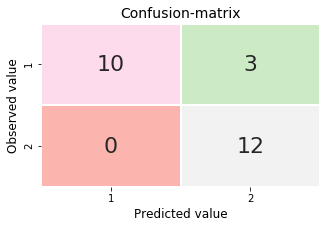

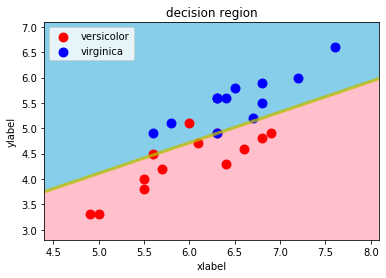

In [57]:
# SVMクラスの初期化
model2 = LinearSVC()

# トレーニングデータで学習
model2.fit(X_train, y_train)

# 予測
y_pred2 = model2.predict(X_test)
y_pred2_train = model2.predict(X_train)

# 評価
print('トレーニングデータの精度')
results21 = classifier_evaluation(y_train, y_pred2_train, pos_label=2)
print('\nテストデータの精度')
results22 = classifier_evaluation(y_test, y_pred2, pos_label=2)

# 混同行列
cf2 = confusion_matrix(y_test, y_pred2)
cfdf2 = pd.DataFrame(cf2, index=[1,2], columns=[1,2])
cf_matrix(cfdf2)

# 可視化
decision_region(np.array(X_test), y_test, model2)

### 決定木

トレーニングデータの精度
Accuracy  : 1.000
Precision : 1.000
Recall    : 1.000
F         : 1.000

テストデータの精度
Accuracy  : 0.880
Precision : 1.000
Recall    : 0.769
F         : 0.870


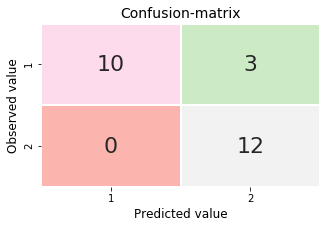

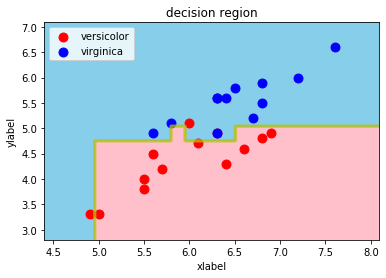

In [58]:
# 決定木クラスの初期化
model3 = DecisionTreeClassifier()

# 学習
model3.fit(X_train, y_train)

# 予測
y_pred3 = model3.predict(X_test)
y_pred3_train = model3.predict(X_train)

# 評価
print('トレーニングデータの精度')
results31 = classifier_evaluation(y_train, y_pred3_train, pos_label=2)
print('\nテストデータの精度')
results32 = classifier_evaluation(y_test, y_pred3, pos_label=2)

# 混同行列
cf3 = confusion_matrix(y_test, y_pred3)
cfdf3 = pd.DataFrame(cf3, index=[1,2], columns=[1,2])
cf_matrix(cfdf3)

# 可視化
decision_region(np.array(X_test), y_test, model3)

### ランダムフォレスト

トレーニングデータの精度
Accuracy  : 1.000
Precision : 1.000
Recall    : 1.000
F         : 1.000

テストデータの精度
Accuracy  : 0.840
Precision : 1.000
Recall    : 0.692
F         : 0.818


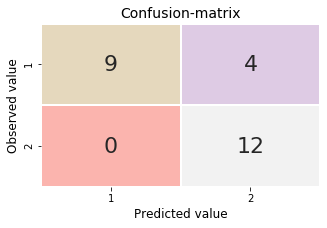

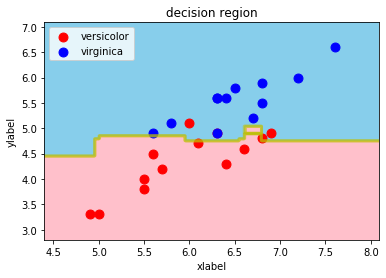

In [59]:
# ランダムフォレストクラスの初期化
model4 = RandomForestClassifier()

# 学習
model4.fit(X_train, y_train)

# 予測
y_pred4 = model4.predict(X_test)
y_pred4_train = model4.predict(X_train)

# 評価
print('トレーニングデータの精度')
results41 = classifier_evaluation(y_train, y_pred4_train, pos_label=2)
print('\nテストデータの精度')
results42 = classifier_evaluation(y_test, y_pred4, pos_label=2)

# 混同行列
cf4 = confusion_matrix(y_test, y_pred4)
cfdf4 = pd.DataFrame(cf4, index=[1,2], columns=[1,2])
cf_matrix(cfdf4)

# 可視化
decision_region(np.array(X_test), y_test, model4)

In [60]:
index = results01.keys()
columns = [['5-nn','5-nn', 
            'LogisticRegression', 'LogisticRegression', 
            'SVM', 'SVM', 
            'DecisionTree', 'DecisionTree', 
            'RandomForest', 'RandomForest'],
           ['train', 'test', 
            'train', 'test', 
            'train', 'test', 
            'train', 'test', 
            'train', 'test']]

results_ndarray2 = np.zeros([4, 10])
results_ndarray2[:, 0] = np.array([i for i in results01.values()])
results_ndarray2[:, 1] = np.array([i for i in results02.values()])
results_ndarray2[:, 2] = np.array([i for i in results11.values()])
results_ndarray2[:, 3] = np.array([i for i in results12.values()])
results_ndarray2[:, 4] = np.array([i for i in results21.values()])
results_ndarray2[:, 5] = np.array([i for i in results22.values()])
results_ndarray2[:, 6] = np.array([i for i in results31.values()])
results_ndarray2[:, 7] = np.array([i for i in results32.values()])
results_ndarray2[:, 8] = np.array([i for i in results41.values()])
results_ndarray2[:, 9] = np.array([i for i in results42.values()])

pd.DataFrame(results_ndarray2, index=index, columns=columns)

5-nn           LogisticRegression                 SVM  \
              train      test              train      test     train   
Accuracy   0.960000  0.920000           0.946667  0.880000  0.946667   
Precision  0.972222  1.000000           0.923077  1.000000  0.945946   
Recall     0.945946  0.846154           0.972973  0.769231  0.945946   
F          0.958904  0.916667           0.947368  0.869565  0.945946   

                    DecisionTree           RandomForest            
               test        train      test        train      test  
Accuracy   0.880000          1.0  0.880000          1.0  0.840000  
Precision  1.000000          1.0  1.000000          1.0  1.000000  
Recall     0.769231          1.0  0.769231          1.0  0.692308  
F          0.869565          1.0  0.869565          1.0  0.818182

## 【問題10】（アドバンス課題）全ての目的変数を使用して精度が高い手法
ここまではアヤメの種類を減らし2値分類を行ってきましたが、3種類全てを使った多値分類を行います。学習と推定、評価を行って、最も精度の高い手法を探してください。

《多値になることでの変更点》

指標値Precision（適合率）、Recall（再現率）、F値はライブラリのパラメータをデフォルトから変更する必要があります。マイクロ平均やマクロ平均という考え方を使います。

決定領域を可視化する前述の関数は適切に書き換える必要があります。以下が出力例です。

<img src="../../img/2.png">

ロジスティック回帰やSVMは2値分類を基本とした手法で、多値分類には工夫が必要ですが、scikit-learnでは自動的に判断して処理が行われるため変更は必要ありません。

### 【結論】
今回の実施内容では、最近傍法が最も精度が高かった。

### データ用意

In [61]:
df3 = df.loc[:, ['sepal_length', 'petal_length', 'target']].copy()
df3.head()

,sepal_length,petal_length,target
0,5.1,1.4,0
1,4.9,1.4,0
2,4.7,1.3,0
3,4.6,1.5,0
4,5.0,1.4,0


In [62]:
X = df3.loc[:, ['sepal_length', 'petal_length']]
y = df3.loc[:, 'target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

### 最近傍法

トレーニングデータの精度
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        37
  virgicolor       0.94      0.91      0.93        34
   virginica       0.93      0.95      0.94        41

    accuracy                           0.96       112
   macro avg       0.96      0.95      0.96       112
weighted avg       0.96      0.96      0.96       112

テストデータの精度
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        13
  virgicolor       1.00      0.94      0.97        16
   virginica       0.90      1.00      0.95         9

    accuracy                           0.97        38
   macro avg       0.97      0.98      0.97        38
weighted avg       0.98      0.97      0.97        38



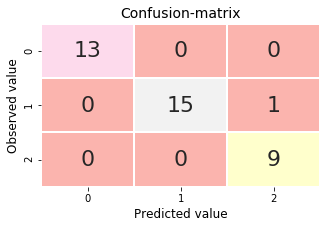

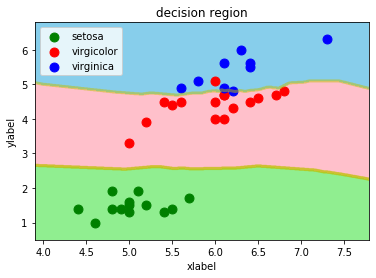

In [63]:
neigh5 = KNeighborsClassifier()
neigh5.fit(X_train, y_train)

y_pred5 = neigh5.predict(X_test)
y_pred5_train = neigh5.predict(X_train)

# 5-nn 評価
target_names = ['setosa', 'virgicolor', 'virginica']
a = classification_report(y_train, y_pred5_train, target_names=target_names)
b = classification_report(y_test, y_pred5, target_names=target_names)
print('トレーニングデータの精度\n', a)
print('テストデータの精度\n', b)

# 混同行列
cf5 = confusion_matrix(y_test, y_pred5)
cfdf5 = pd.DataFrame(cf5, index=[0, 1, 2], columns=[0, 1, 2])
cf_matrix(cfdf5)

# 可視化
decision_region(np.array(X_test), y_test, neigh5, n_class=3, target_names=target_names)

### ロジスティック回帰

トレーニングデータの精度
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        37
  virgicolor       0.97      0.91      0.94        34
   virginica       0.93      0.98      0.95        41

    accuracy                           0.96       112
   macro avg       0.97      0.96      0.96       112
weighted avg       0.96      0.96      0.96       112

テストデータの精度
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        13
  virgicolor       0.94      0.94      0.94        16
   virginica       0.89      0.89      0.89         9

    accuracy                           0.95        38
   macro avg       0.94      0.94      0.94        38
weighted avg       0.95      0.95      0.95        38



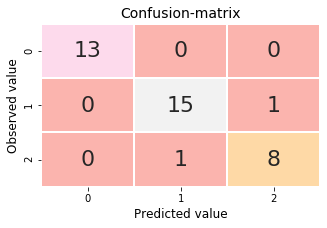

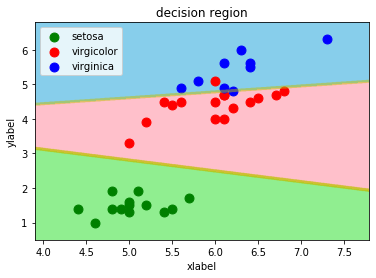

In [64]:
# ロジスティック回帰クラスを初期化
model1 = LogisticRegression()

# トレーニングデータで学習
model1.fit(X_train, y_train)

# 予測
y_pred1 = model1.predict(X_test)
y_pred1_train = model1.predict(X_train)

# # 評価
target_names = ['setosa', 'virgicolor', 'virginica']
a = classification_report(y_train, y_pred1_train, target_names=target_names)
b = classification_report(y_test, y_pred1, target_names=target_names)
print('トレーニングデータの精度\n', a)
print('テストデータの精度\n', b)

# 混同行列
cf1 = confusion_matrix(y_test, y_pred1)
cfdf1 = pd.DataFrame(cf1, index=[0, 1, 2], columns=[0, 1, 2])
cf_matrix(cfdf1)

# 可視化
decision_region(np.array(X_test), y_test, model1, n_class=3, target_names=target_names)

### サポートベクターマシン

トレーニングデータの精度
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        37
  virgicolor       1.00      0.88      0.94        34
   virginica       0.91      1.00      0.95        41

    accuracy                           0.96       112
   macro avg       0.97      0.96      0.96       112
weighted avg       0.97      0.96      0.96       112

テストデータの精度
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        13
  virgicolor       1.00      0.62      0.77        16
   virginica       0.60      1.00      0.75         9

    accuracy                           0.84        38
   macro avg       0.87      0.88      0.84        38
weighted avg       0.91      0.84      0.84        38



/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


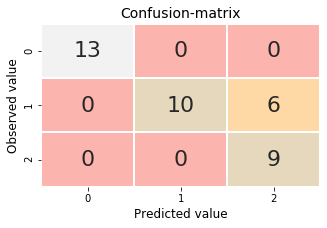

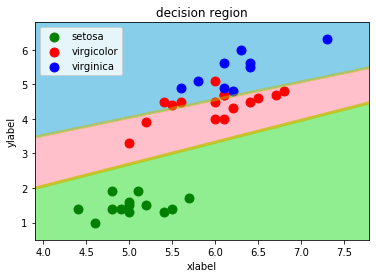

In [65]:
# SVMクラスの初期化
model2 = LinearSVC()

# トレーニングデータで学習
model2.fit(X_train, y_train)

# 予測
y_pred2 = model2.predict(X_test)
y_pred2_train = model2.predict(X_train)

# 評価
target_names = ['setosa', 'virgicolor', 'virginica']
a = classification_report(y_train, y_pred2_train, target_names=target_names)
b = classification_report(y_test, y_pred2, target_names=target_names)
print('トレーニングデータの精度\n', a)
print('テストデータの精度\n', b)

# 混同行列
cf2 = confusion_matrix(y_test, y_pred2)
cfdf2 = pd.DataFrame(cf2, index=[0, 1, 2], columns=[0, 1, 2])
cf_matrix(cfdf2)

# 可視化
decision_region(np.array(X_test), y_test, model2, n_class=3, target_names=target_names)

### 決定木

トレーニングデータの精度
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        37
  virgicolor       0.97      1.00      0.99        34
   virginica       1.00      0.98      0.99        41

    accuracy                           0.99       112
   macro avg       0.99      0.99      0.99       112
weighted avg       0.99      0.99      0.99       112

テストデータの精度
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        13
  virgicolor       0.88      0.88      0.88        16
   virginica       0.78      0.78      0.78         9

    accuracy                           0.89        38
   macro avg       0.88      0.88      0.88        38
weighted avg       0.89      0.89      0.89        38



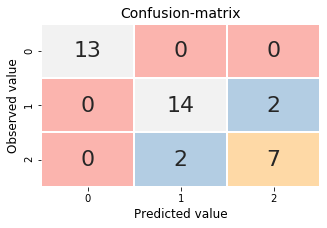

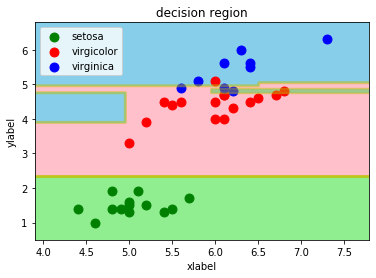

In [66]:
# 決定木クラスの初期化
model3 = DecisionTreeClassifier()

# 学習
model3.fit(X_train, y_train)

# 予測
y_pred3 = model3.predict(X_test)
y_pred3_train = model3.predict(X_train)

# 評価
target_names = ['setosa', 'virgicolor', 'virginica']
a = classification_report(y_train, y_pred3_train, target_names=target_names)
b = classification_report(y_test, y_pred3, target_names=target_names)
print('トレーニングデータの精度\n', a)
print('テストデータの精度\n', b)

# 混同行列
cf3 = confusion_matrix(y_test, y_pred3)
cfdf3 = pd.DataFrame(cf3, index=[0, 1, 2], columns=[0, 1, 2])
cf_matrix(cfdf3)

# 可視化
decision_region(np.array(X_test), y_test, model3, n_class=3, target_names=target_names)

### ランダムフォレスト

トレーニングデータの精度
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        37
  virgicolor       0.97      1.00      0.99        34
   virginica       1.00      0.98      0.99        41

    accuracy                           0.99       112
   macro avg       0.99      0.99      0.99       112
weighted avg       0.99      0.99      0.99       112

テストデータの精度
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        13
  virgicolor       0.94      0.94      0.94        16
   virginica       0.89      0.89      0.89         9

    accuracy                           0.95        38
   macro avg       0.94      0.94      0.94        38
weighted avg       0.95      0.95      0.95        38



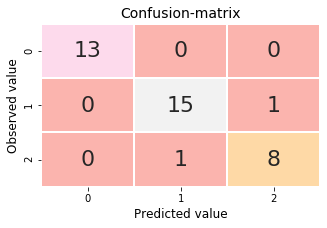

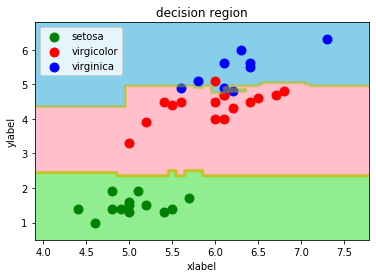

In [67]:
# ランダムフォレストクラスの初期化
model4 = RandomForestClassifier()

# 学習
model4.fit(X_train, y_train)

# 予測
y_pred4 = model4.predict(X_test)
y_pred4_train = model4.predict(X_train)

# 評価
target_names = ['setosa', 'virgicolor', 'virginica']
a = classification_report(y_train, y_pred4_train, target_names=target_names)
b = classification_report(y_test, y_pred4, target_names=target_names)
print('トレーニングデータの精度\n', a)
print('テストデータの精度\n', b)

# 混同行列
cf4 = confusion_matrix(y_test, y_pred4)
cfdf4 = pd.DataFrame(cf4, index=[0, 1, 2], columns=[0, 1, 2])
cf_matrix(cfdf4)

# 可視化
decision_region(np.array(X_test), y_test, model4, n_class=3, target_names=target_names)